# Creating the Edgelist and Importing Data

C'era stata un'imprecisione nella creazione della edgelist pesata nell'altro script, devo ricreare la edgelist (non cambia l'analisi già svolta)

In [ ]:
'''
# creating the edgelist (+- 17 min)

# each node is a user that has posted at least one time in 2022

# edges are defined as interaction in terms of comments under posts only

import csv
from google.colab import drive

drive.mount('/content/gdrive')

# input and output files
input_file       = r"/content/gdrive/MyDrive/dati_sna/comments_decimato_2022.csv"
submissions_file = r"/content/gdrive/MyDrive/dati_sna/submissions_decimato_2022.csv"
output_file      = r"/content/gdrive/MyDrive/dati_sna/edgelist_2022_weighted.csv"

# loading input file's rows (comments)
rows = []
with open(input_file, mode='r') as file:
    csvreader = csv.reader(file)
    next(csvreader)  # skipping first row
    for row in csvreader:
        # discarding deleted users
        if row[0] != 'u/[deleted]':
            rows.append(row)

# loading sumbissions into a dictionary id-author
sub_rows = []
submissions_dict = {}
with open(submissions_file, mode='r') as file:
    csvreader = csv.reader(file)
    next(csvreader) # skipping first row
    for row in csvreader:
        # discarding deleted users
        if row[0] != 'u/[deleted]':
            author, sub_id , title, score , created= row
            submissions_dict[sub_id] = author
            sub_rows.append(row)

# lista delle coppie di autori con contatore di interazioni
from collections import defaultdict
author_pairs = defaultdict(int)

i = 0

# controlliamo se id (della submission) == parent_id_trimmed (del commento)
for row in rows:
    if len(row) == 6:
        author, parent_id, comment_id, body, score, created = row
        parent_id_trimmed = parent_id[3:] if len(parent_id) > 3 else parent_id

    # se il commento è sotto una submission, aggiorniamo il conteggio
    if parent_id_trimmed in submissions_dict:
        author_submission = submissions_dict[parent_id_trimmed]
        if i % 1000 == 0:
            print(i, "confronti fatti")
        i += 1
        if author in submissions_dict.values():
            author_pairs[(author, author_submission)] += 1  # Incrementa il conteggio

# Scriviamo il risultato in un CSV includendo il numero di interazioni
with open(output_file, mode='w', newline='') as file:
    csvwriter = csv.writer(file)
    csvwriter.writerow(['author1', 'author2', 'weight'])  # Aggiungiamo il peso
    for (author1, author2), weight in author_pairs.items():
        csvwriter.writerow([author1, author2, weight])

print(f"Lista di autori con pesi scritta in: {output_file}")

This script creates 3 different edgelists (graph, graph_weigthed, graph_weigthed_directed).

This also loads the data computed in the LLAMA script.

In [ ]:
%%capture
# importing libraries
!pip install networkx
import networkx as nx
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
warnings.filterwarnings('ignore')

# loading the edgelist from the cloud
drive.mount('/content/gdrive')
%matplotlib inline

# Caricare il CSV in un DataFrame
csv_path = "/content/gdrive/MyDrive/dati_sna/edgelist_2022_weighted.csv"
df = pd.read_csv(csv_path)

### Creazione del Grafo Pesato ###
graph_weighted = nx.from_pandas_edgelist(df, source="author1", target="author2", edge_attr="weight", create_using=nx.Graph())

### Creazione del Grafo Non Pesato ###
graph = nx.from_pandas_edgelist(df, source="author1", target="author2", create_using=nx.Graph())

### Creazione del Grafo Diretto ###
graph_directed = nx.from_pandas_edgelist(df, source="author1", target="author2", create_using=nx.DiGraph())

# importing data
veg_titles   = pd.read_csv("/content/gdrive/MyDrive/dati_sna/veg_titles_2022.csv"  ) # vegetarian/omnivorous
sweet_titles = pd.read_csv("/content/gdrive/MyDrive/dati_sna/sweet_titles_2022.csv") # sweet/savoury
tag_titles   = pd.read_csv("/content/gdrive/MyDrive/dati_sna/tag_titles_2022.csv"  ) # [i ate]/[homemade]/[pro/chef]

# Datasets Preprocessing

We want to make a standardized version of the extracted data to simplify further analysis. This script creates a dataset where the only possible values in the classification section are vegetarian/omnivorous/unknown

In [ ]:
import pandas as pd

def clean_classification(input_csv, output_csv):
    # Carica il CSV
    df = pd.read_csv(input_csv)

    # Definisce le classificazioni valide (in minuscolo per confronto)
    valid_classifications = {"vegetarian", "omnivorous"}

    # Normalizza i valori a minuscolo e sostituisce quelli non validi con "UNKNOWN"
    df["classification"] = df["classification"].str.lower().apply(lambda x: x if x in valid_classifications else "unknown")

    # Salva il file modificato in un nuovo file
    df.to_csv(output_csv, index=False)
    print(f"File aggiornato con successo e salvato come {output_csv}!")

# Esempio di utilizzo
clean_classification("/content/gdrive/MyDrive/dati_sna/veg_titles_2022.csv", "/content/gdrive/MyDrive/dati_sna/veg_titles_2022_cleaned.csv")


File aggiornato con successo e salvato come /content/gdrive/MyDrive/dati_sna/veg_titles_2022_cleaned.csv!


Same thing as above for the sweet/savory

In [ ]:
import pandas as pd

def clean_classification(input_csv, output_csv):
    # Carica il CSV
    df = pd.read_csv(input_csv)

    # Definisce le classificazioni valide (in minuscolo per confronto)
    valid_classifications = {"sweet", "savory"}

    # Normalizza i valori a minuscolo e sostituisce quelli non validi con "UNKNOWN"
    df["classification"] = df["classification"].str.lower().apply(lambda x: x if x in valid_classifications else "unknown")

    # Salva il file modificato in un nuovo file
    df.to_csv(output_csv, index=False)
    print(f"File aggiornato con successo e salvato come {output_csv}!")

# Esempio di utilizzo
clean_classification("/content/gdrive/MyDrive/dati_sna/sweet_titles_2022.csv", "/content/gdrive/MyDrive/dati_sna/sweet_titles_2022_cleaned.csv")


File aggiornato con successo e salvato come /content/gdrive/MyDrive/dati_sna/sweet_titles_2022_cleaned.csv!


For the ethnic classification we have to first analyze which nations are classified by the LLM

In [ ]:
import pandas as pd
from google.colab import drive

# loading the edgelist from the cloud
drive.mount('/content/gdrive')
# Percorso del file CSV
file_path = "/content/gdrive/MyDrive/dati_sna/ethnic_titles_2022.csv"

# Leggere il file CSV
df = pd.read_csv(file_path)

# Contare le occorrenze di ogni classificazione
classification_counts = df["classification"].value_counts()

# Stampare le classificazioni con il numero di occorrenze
for classification, count in classification_counts.items():
    print(f"{classification}: {count}")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
American: 27780
Chinese: 17189
French: 8513
Italian: 5769
Mexican: 2553
Japanese: 2211
Middle: 2111
British: 1676
-: 1069
Indian: 1003
Greek: 972
Korean: 885
German: 721
(no: 715
Unknown: 594
[American]: 515
Spanish: 398
Vietnamese: 382
(Note:: 355
Asian: 302
#: 277
[Chinese]: 240
Southern: 226
Russian: 226
Caribbean: 216
Hawaiian: 180
Various: 177
African: 174
Fruit: 168
Brazilian: 165
[French]: 164
Turkish: 159
Polish: 144
I: 144
Jewish: 141
Latin: 136
Irish: 134
Southeast: 125
Australian: 123
Thai: 121
Fruit-based: 120
Canadian: 109
Swedish: 109
[Italian]: 105
Other: 98
Not: 96
Filipino: 85
(No: 84
[homemade: 81
Scottish: 79
Seafood: 75
British/Scott: 75
Portuguese: 75
No: 72
Peruvian: 67
Hungarian: 66
Dutch: 62
British/English: 62
British/: 62
[Middle: 58
(I: 57
[Homemade: 55
I'm: 53
Scandinavian: 50
South: 49
Georgian: 49
(American): 48
European: 46
BB

Adjusting ambiguous classifications and filtering manually the bad classifications

In [ ]:
import pandas as pd
import re
from google.colab import drive

# Caricare Google Drive
drive.mount('/content/gdrive')

# Percorso del file CSV di origine
file_path = "/content/gdrive/MyDrive/dati_sna/ethnic_titles_2022.csv"
# Percorso del file CSV di destinazione
output_path = "/content/gdrive/MyDrive/dati_sna/ethnic_titles_2022_cleaned.csv"

# Leggere il file CSV
df = pd.read_csv(file_path)

# Definire le classificazioni da mantenere, considerate le classificazioni per almeno 10 post
valid_classifications = ["American", "Chinese", "French", "Italian", "Mexican", "Japanese", "Middle",
                         "British", "Indian", "Greek", "Korean", "German", "Spanish", "Vietnamese",
                         "Asian", "Russian", "Caribbean", "Hawaiian", "African", "Brazilian", "Turkish",
                         "Polish", "Jewish", "Latin", "Irish", "Southeast", "Australian", "Thai", "Canadian",
                         "Swedish", "Filipino", "Scottish", "Portuguese", "Peruvian", "Hungarian", "Dutch",
                         "Scandinavian", "Georgian", "Ukrainian", "Ethiopian", "Belgian", "Swiss", "Jamaican",
                         "Cuban", "Persian", "Argentine", "Romanian", "Czech", "Iranian", "Danish",
                         "Austrian", "Norwegian", "Colombian"]

# Funzione per rimuovere le parentesi quadre
def clean_classification(classification):
    if isinstance(classification, str):  # Verifica che sia una stringa
        return re.sub(r'\[|\]', '', classification)
    return "unknown"  # Se non è una stringa, sostituiscilo con "unknown"

# Applicare la funzione di pulizia
df["classification"] = df["classification"].apply(clean_classification)

# Sostituire le classificazioni non presenti nella lista con "unknown"
df["classification"] = df["classification"].apply(lambda x: x if x in valid_classifications else "unknown")

# Salvare il nuovo file CSV
df.to_csv(output_path, index=False)

print(f"File salvato in {output_path}")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
File salvato in /content/gdrive/MyDrive/dati_sna/ethnic_titles_2022_cleaned.csv


In [ ]:
import pandas as pd
from google.colab import drive

# loading the edgelist from the cloud
drive.mount('/content/gdrive')
# Percorso del file CSV
file_path = "/content/gdrive/MyDrive/dati_sna/ethnic_titles_2022_cleaned.csv"

# Leggere il file CSV
df = pd.read_csv(file_path)

# Contare le occorrenze di ogni classificazione
classification_counts = df["classification"].value_counts()
i=0
# Stampare le classificazioni con il numero di occorrenze
for classification, count in classification_counts.items():
    print(f"{classification}: {count}")
    i=i+1

print("\nNumber of ethnicities (at least 10 posts):", i)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
American: 28295
Chinese: 17429
French: 8677
unknown: 7937
Italian: 5874
Mexican: 2576
Japanese: 2227
Middle: 2169
British: 1680
Indian: 1039
Greek: 992
Korean: 886
German: 729
Spanish: 417
Vietnamese: 382
Asian: 307
Russian: 228
Caribbean: 216
Hawaiian: 180
African: 174
Brazilian: 165
Turkish: 160
Latin: 152
Polish: 147
Jewish: 141
Irish: 134
Southeast: 128
Australian: 123
Thai: 121
Canadian: 110
Swedish: 109
Filipino: 85
Scottish: 79
Portuguese: 75
Hungarian: 71
Peruvian: 67
Dutch: 62
Scandinavian: 50
Georgian: 49
Ukrainian: 35
Ethiopian: 31
Belgian: 30
Swiss: 29
Jamaican: 28
Cuban: 27
Persian: 20
Argentine: 15
Romanian: 14
Czech: 14
Iranian: 12
Norwegian: 12
Danish: 11
Austrian: 11
Colombian: 10

Number of ethnicities (at least 10 posts): 54


# Vegetarian/Omnivorous Analysis

## Labeling Nodes

Labeling each node, with a majority rule of posted contents, in vegetarian/omnivorous/unknown

In [ ]:
import networkx as nx
import pandas as pd
from collections import Counter

# Carica il CSV
df = pd.read_csv("/content/gdrive/MyDrive/dati_sna/veg_titles_2022_cleaned.csv")

# Troviamo tutte le componenti connesse
components = list(nx.connected_components(graph_weighted))

# Troviamo la componente connessa più grande
largest_component = max(components, key=len)

# Creiamo un nuovo grafo contenente solo la componente più grande (preservando i pesi)
G = graph_weighted.subgraph(largest_component).copy()

# Crea un dizionario che mappa ogni autore alla classificazione basata su tutte le sue etichette
author_labels = {}
for author, group in df.groupby("author"):
    label_counts = Counter(group["classification"])  # Conta quante volte compaiono vegetarian/omnivorous

    veg_count = label_counts.get("vegetarian", 0)
    omni_count = label_counts.get("omnivorous", 0)

    # Se il numero di vegetariani è uguale a quello degli omnivori, l'etichetta sarà 'unknown'
    if veg_count == omni_count and veg_count > 0:  # Se sono uguali e > 0 → 'unknown'
        author_labels[author] = "unknown"
    else:
        # Altrimenti, assegna l'etichetta più frequente
        most_common_label = max(label_counts, key=label_counts.get)
        author_labels[author] = most_common_label

# Assegna le etichette ai nodi del grafo
to_remove = []  # Per rimuovere eventuali nodi non presenti nel CSV
for node in G.nodes:
    if node in author_labels:
        G.nodes[node]["label"] = author_labels[node]
    else:
        to_remove.append(node)

# Rimuovi nodi che non hanno etichetta
G.remove_nodes_from(to_remove)

Performing label propagation in order to classify the unknown nodes

In [ ]:
import networkx as nx
import random

def label_propagation(G, max_iter=10):
    for _ in range(max_iter):
        for node in G.nodes:
            if G.nodes[node]['label'] == 'unknown':
                neighbor_labels = [G.nodes[n]['label'] for n in G.neighbors(node) if G.nodes[n]['label'] != 'unknown']
                if neighbor_labels:
                    # Assegna la label più frequente tra i vicini
                    G.nodes[node]['label'] = max(set(neighbor_labels), key=neighbor_labels.count)

# Applicare la propagazione delle etichette
label_propagation(G)

valid_labels = {"vegetarian", "omnivorous"}

# Estrai tutte le etichette dei nodi
node_labels = set(nx.get_node_attributes(G, 'label').values())

# Controlla se ci sono solo le etichette attese
if node_labels.issubset(valid_labels):
    print("Tutti i nodi hanno etichette valide.")
else:
    print("Ci sono etichette non valide:", node_labels - valid_labels)


Tutti i nodi hanno etichette valide.


In [ ]:
import networkx as nx
import csv

def save_graph_labels(G, filename):

    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Node", "Label"])  # Column headers

        for node, data in G.nodes(data=True):
            label = data.get("label", "")  # Get label if it exists, otherwise empty string
            writer.writerow([node, label])


save_graph_labels(G, "/content/gdrive/MyDrive/dati_sna/veg_nodes_labeled.csv")

## Centrality analysis

Degree centrality vs labels

In [ ]:
# Calcola metriche di centralità
centrality = nx.degree_centrality(G)

# Analizza la distribuzione delle etichette tra i nodi più centrali
sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

# Conta le etichette nei 10 utenti più influenti
label_counts = Counter(G.nodes[node]['label'] for node, _ in sorted_centrality[:100]) # Varying this number we consider the k highest degree centrality nodes

#for node, score in sorted_centrality[:10]:  # Considera i 10 utenti più influenti
    #print(f"Autore: {node}, Centralità: {score}, Etichetta: {G.nodes[node]['label']}")

print("Distribuzione etichette tra i nodi più centrali:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

Distribuzione etichette tra i nodi più centrali:
vegetarian: 62
omnivorous: 38


When we use the majority rule to label the nodes the number of omnivorous and vegetarians is balanced, in the version based on strictly vegetarians the majority of users is considered to be omnivorous but still in the same order of magnitude

Assortativity

In [ ]:
import networkx as nx

def calculate_diet_assortativity(G):
    """
    Calcola l'assortatività del grafo G basata sull'etichetta dei nodi ("vegetarian" o "omnivorous").

    Parametri:
        G (networkx.Graph): Grafo con nodi che hanno già un'etichetta come attributo.

    Ritorna:
        float: Valore dell'assortatività
    """

    # Controlliamo che i nodi abbiano l'attributo 'label'
    if not all("label" in G.nodes[n] for n in G.nodes):
        raise ValueError("Tutti i nodi devono avere un'etichetta 'label' ('vegetarian' o 'omnivorous').")

    # Rinominiamo l'attributo 'label' in 'diet' per calcolare l'assortatività
    nx.set_node_attributes(G, {n: G.nodes[n]["label"] for n in G.nodes}, "diet")

    # Calcoliamo l'assortatività rispetto alla dieta
    assortativity = nx.attribute_assortativity_coefficient(G, "diet")

    return assortativity



# Calcoliamo l'assortatività
assortativity = calculate_diet_assortativity(G)

# Stampiamo il risultato
print(f"Assortatività rispetto alla dieta: {assortativity:.3f}")

Assortatività rispetto alla dieta: 0.123


Diet modularity

In [ ]:
import networkx as nx
import networkx.algorithms.community as nx_comm

def calculate_diet_modularity(G):
    """
    Calcola la modularità del grafo rispetto alla dieta.
    """
    # Creiamo le comunità in base alla dieta
    vegetarian_nodes = {n for n in G.nodes if G.nodes[n]["label"] == "vegetarian"}
    omnivorous_nodes = {n for n in G.nodes if G.nodes[n]["label"] == "omnivorous"}

    communities = [vegetarian_nodes, omnivorous_nodes]

    # Calcoliamo la modularità
    return nx_comm.modularity(G, communities)

# computing and printing out
modularity = calculate_diet_modularity(G)
print(f"Modularità rispetto alla dieta: {modularity:.3f}")

Modularità rispetto alla dieta: 0.092


Valori di assortatività e modularità così bassi suggeriscono che non avviene una distinzione netta tra i due gruppi, almeno sono entrambi positivi. Da provare andando a selezionare i vegetariani sulla SOLA presenza di cibi veg e non sulla majority rule (provato e sia assortatività che modularità sono più basse, 0.041 e 0.029).

In [ ]:
import networkx as nx

def homophily_by_label(G):
    """
    Calcola l'omofilia basata sulle etichette di un grafo G.
    """
    same_label_edges = 0
    total_edges = 0

    for u, v, data in G.edges(data=True):
        total_edges += 1
        if G.nodes[u]['label'] == G.nodes[v]['label']:
            same_label_edges += 1

    return same_label_edges / total_edges if total_edges > 0 else 0


def weighted_homophily(G):
    """
    Calcola l'omofilia ponderata basata sulle etichette di un grafo G.
    """
    same_label_weighted_edges = 0
    total_weighted_edges = 0

    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1)  # Se non c'è peso, assume 1
        total_weighted_edges += weight
        if G.nodes[u]['label'] == G.nodes[v]['label']:
            same_label_weighted_edges += weight

    return same_label_weighted_edges / total_weighted_edges if total_weighted_edges > 0 else 0

# Calcola l'omofilia basata sulle etichette
omofilia_etichetta = homophily_by_label(G)
print(f"Omofilia basata sulle etichette: {omofilia_etichetta:.2f}")

# Calcola l'omofilia ponderata
omofilia_ponderata = weighted_homophily(G)
print(f"Omofilia ponderata: {omofilia_ponderata:.2f}")

Omofilia basata sulle etichette: 0.61
Omofilia ponderata: 0.63


# Sweet/Savoury Analysis

## Labeling Nodes

Labeling each node, with a majority rule of posted contents, in sweet/savory/unknown

In [ ]:
import networkx as nx
import pandas as pd
from collections import Counter

df = pd.read_csv("/content/gdrive/MyDrive/dati_sna/sweet_titles_2022_cleaned.csv")

# Troviamo tutte le componenti connesse
components = list(nx.connected_components(graph))

# Troviamo la componente connessa più grande
largest_component = max(components, key=len)

# Ora possiamo creare un nuovo grafo che contenga solo la componente più grande
G = graph.subgraph(largest_component).copy()


# Crea un dizionario che mappa ogni autore alla classificazione più frequente
author_labels = {}
for author, group in df.groupby("author"):
    most_common_label = Counter(group["classification"]).most_common(1)[0][0]
    author_labels[author] = most_common_label


# Assegna le etichette ai nodi
to_remove = []  # Per rimuovere eventuali nodi non presenti nel CSV
for node in G.nodes:
    if node in author_labels:
        G.nodes[node]["label"] = author_labels[node]
    else:
        to_remove.append(node)

Performing label propagation in order to classify the unknown nodes

In [ ]:
import networkx as nx
import random

def label_propagation(G, max_iter=10):
    for _ in range(max_iter):
        for node in G.nodes:
            if G.nodes[node]['label'] == 'unknown':
                neighbor_labels = [G.nodes[n]['label'] for n in G.neighbors(node) if G.nodes[n]['label'] != 'unknown']
                if neighbor_labels:
                    # Assegna la label più frequente tra i vicini
                    G.nodes[node]['label'] = max(set(neighbor_labels), key=neighbor_labels.count)

# Applicare la propagazione delle etichette
label_propagation(G)

valid_labels = {"sweet", "savory"}

# Estrai tutte le etichette dei nodi
node_labels = set(nx.get_node_attributes(G, 'label').values())

# Controlla se ci sono solo le etichette attese
if node_labels.issubset(valid_labels):
    print("Tutti i nodi hanno etichette valide.")
else:
    print("Ci sono etichette non valide:", node_labels - valid_labels)


Tutti i nodi hanno etichette valide.


In [ ]:
import networkx as nx
import csv

def save_graph_labels(G, filename):

    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Node", "Label"])  # Column headers

        for node, data in G.nodes(data=True):
            label = data.get("label", "")  # Get label if it exists, otherwise empty string
            writer.writerow([node, label])


save_graph_labels(G, "/content/gdrive/MyDrive/dati_sna/swe_nodes_labeled.csv")

## Centrality analysis

Degree centrality vs labels

In [ ]:
# Calcola metriche di centralità
centrality = nx.degree_centrality(G)

# Analizza la distribuzione delle etichette tra i nodi più centrali
sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

# Conta le etichette nei 10 utenti più influenti
label_counts = Counter(G.nodes[node]['label'] for node, _ in sorted_centrality[:1000]) # Varying this number we consider the k highest degree centrality nodes

#for node, score in sorted_centrality[:10]:  # Considera i 10 utenti più influenti
    #print(f"Autore: {node}, Centralità: {score}, Etichetta: {G.nodes[node]['label']}")

print("Distribuzione etichette tra i nodi più centrali:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

Distribuzione etichette tra i nodi più centrali:
savory: 924
sweet: 76


The number of sweet users is more or less one order of magnitude lower than the savory ones.

Assortativity

In [ ]:
import networkx as nx

def calculate_diet_assortativity(G):
    """
    Calcola l'assortatività del grafo G basata sull'etichetta dei nodi ("vegetarian" o "omnivorous").

    Parametri:
        G (networkx.Graph): Grafo con nodi che hanno già un'etichetta come attributo.

    Ritorna:
        float: Valore dell'assortatività
    """

    # Controlliamo che i nodi abbiano l'attributo 'label'
    if not all("label" in G.nodes[n] for n in G.nodes):
        raise ValueError("Tutti i nodi devono avere un'etichetta 'label' ('sweet' o 'savory').")

    # Rinominiamo l'attributo 'label' in 'diet' per calcolare l'assortatività
    nx.set_node_attributes(G, {n: G.nodes[n]["label"] for n in G.nodes}, "diet")

    # Calcoliamo l'assortatività rispetto alla dieta
    assortativity = nx.attribute_assortativity_coefficient(G, "diet")

    return assortativity



# Calcoliamo l'assortatività
assortativity = calculate_diet_assortativity(G)

# Stampiamo il risultato
print(f"Assortatività rispetto alla dieta: {assortativity:.3f}")

Assortatività rispetto alla dieta: 0.088


Diet modularity

In [ ]:
import networkx as nx
import networkx.algorithms.community as nx_comm

def calculate_diet_modularity(G):
    """
    Calcola la modularità del grafo rispetto alla dieta.
    """
    # Creiamo le comunità in base alla dieta
    sweet_nodes = {n for n in G.nodes if G.nodes[n]["label"] == "sweet"}
    savory_nodes = {n for n in G.nodes if G.nodes[n]["label"] == "savory"}

    communities = [sweet_nodes, savory_nodes]

    # Calcoliamo la modularità
    return nx_comm.modularity(G, communities)

# computing and printing out
modularity = calculate_diet_modularity(G)
print(f"Modularità rispetto alla dieta: {modularity:.3f}")

Modularità rispetto alla dieta: 0.020


In [ ]:
import networkx as nx

def homophily_by_label(G):
    """
    Calcola l'omofilia basata sulle etichette di un grafo G.
    """
    same_label_edges = 0
    total_edges = 0

    for u, v, data in G.edges(data=True):
        total_edges += 1
        if G.nodes[u]['label'] == G.nodes[v]['label']:
            same_label_edges += 1

    return same_label_edges / total_edges if total_edges > 0 else 0


def weighted_homophily(G):
    """
    Calcola l'omofilia ponderata basata sulle etichette di un grafo G.
    """
    same_label_weighted_edges = 0
    total_weighted_edges = 0

    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1)  # Se non c'è peso, assume 1
        total_weighted_edges += weight
        if G.nodes[u]['label'] == G.nodes[v]['label']:
            same_label_weighted_edges += weight

    return same_label_weighted_edges / total_weighted_edges if total_weighted_edges > 0 else 0

# Calcola l'omofilia basata sulle etichette
omofilia_etichetta = homophily_by_label(G)
print(f"Omofilia basata sulle etichette: {omofilia_etichetta:.2f}")

# Calcola l'omofilia ponderata
omofilia_ponderata = weighted_homophily(G)
print(f"Omofilia ponderata: {omofilia_ponderata:.2f}")

Omofilia basata sulle etichette: 0.87
Omofilia ponderata: 0.87


# [i ate], [homemade], [pro/chef]

## Labeling Nodes

Replacing each istance of [pro/chef] into [homemade] since the recipes are still handmade and in order to maintain a binary classification for further analysis

Labeling each node, with a majority rule of posted contents, in sweet/savory/unknown

In [ ]:
import networkx as nx
import pandas as pd
from collections import Counter

df = pd.read_csv("/content/gdrive/MyDrive/dati_sna/tag_titles_2022.csv")

# Sostituisci "UNKNOWN" con un valore nullo (NaN)
df["classification"] = df["classification"].replace("UNKNOWN", pd.NA)

# Converte i valori numerici in interi, ignorando gli NaN
df["classification"] = pd.to_numeric(df["classification"], errors="coerce")

# Sostituisci tutti i 2 con 1
df["classification"] = df["classification"].replace(2, 1)

# Troviamo tutte le componenti connesse
components = list(nx.connected_components(graph))

# Troviamo la componente connessa più grande
largest_component = max(components, key=len)

# Ora possiamo creare un nuovo grafo che contenga solo la componente più grande
G = graph.subgraph(largest_component).copy()

# Crea un dizionario che mappa ogni autore alla classificazione più frequente (ignorando NaN)
author_labels = {}
for author, group in df.groupby("author"):
    valid_classifications = group["classification"].dropna()  # Ignora gli UNKNOWN
    if not valid_classifications.empty:
        most_common_label = Counter(valid_classifications).most_common(1)[0][0]
        author_labels[author] = most_common_label

# Assegna le etichette ai nodi
to_remove = []  # Per rimuovere eventuali nodi non presenti nel CSV
for node in G.nodes:
    if node in author_labels:
        G.nodes[node]["label"] = author_labels[node]
    else:
        to_remove.append(node)

# Controllo finale: stampa i nodi con label 2 (dovrebbero essere 0)
nodes_with_label_2 = [node for node, data in G.nodes(data=True) if data.get("label") == 2]
print(f"Nodi con label 2: {nodes_with_label_2}")  # Dovrebbe stampare []


Nodi con label 2: []


Performing label propagation in order to classify the unknown nodes

In [ ]:
import networkx as nx
import random

def label_propagation(G, max_iter=10):
    for _ in range(max_iter):
        for node in G.nodes:
            if G.nodes[node].get('label') is None:  # Usa .get() per evitare KeyError
                neighbor_labels = [G.nodes[n].get('label') for n in G.neighbors(node) if G.nodes[n].get('label') is not None]
                if neighbor_labels:
                    # Assegna la label più frequente tra i vicini
                    G.nodes[node]['label'] = max(set(neighbor_labels), key=neighbor_labels.count)
                else:
                    # Se non ha vicini etichettati, assegna un'etichetta casuale (evita blocchi)
                    G.nodes[node]['label'] = random.choice([0, 1])

# Converti gli 'UNKNOWN' in None (se presenti)
for node in G.nodes:
    if G.nodes[node].get('label') == 'UNKNOWN':
        G.nodes[node]['label'] = None

# Applica la propagazione delle etichette
label_propagation(G)

valid_labels = {0, 1}

# Estrai tutte le etichette dei nodi
node_labels = set(nx.get_node_attributes(G, 'label').values())

# Controlla se ci sono solo le etichette attese
if node_labels.issubset(valid_labels):
    print("✅ Tutti i nodi hanno etichette valide.")
else:
    print("⚠️ Ci sono etichette non valide:", node_labels - valid_labels)


✅ Tutti i nodi hanno etichette valide.


In [ ]:
import networkx as nx
import csv

def save_graph_labels(G, filename):

    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Node", "Label"])  # Column headers

        for node, data in G.nodes(data=True):
            label = data.get("label", "")  # Get label if it exists, otherwise empty string
            writer.writerow([node, label])


save_graph_labels(G, "/content/gdrive/MyDrive/dati_sna/tag_nodes_labeled.csv")

## Centrality analysis

Degree centrality vs labels

In [ ]:
# Calcola metriche di centralità
centrality = nx.degree_centrality(G)

# Analizza la distribuzione delle etichette tra i nodi più centrali
sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

# Conta le etichette nei 10 utenti più influenti
label_counts = Counter(G.nodes[node]['label'] for node, _ in sorted_centrality[:100000]) # Varying this number we consider the k highest degree centrality nodes

#for node, score in sorted_centrality[:10]:  # Considera i 10 utenti più influenti
    #print(f"Autore: {node}, Centralità: {score}, Etichetta: {G.nodes[node]['label']}")

print("Distribuzione etichette tra i nodi più centrali:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

Distribuzione etichette tra i nodi più centrali:
1.0: 14508
0.0: 3457


0: [i ate]
1: [homemade]

Assortativity

In [ ]:
import networkx as nx

def calculate_diet_assortativity(G):

    # Controlliamo che i nodi abbiano l'attributo 'label'
    if not all("label" in G.nodes[n] for n in G.nodes):
        raise ValueError("Tutti i nodi devono avere un'etichetta 'label' ('0' o '1' o '2').")

    # Rinominiamo l'attributo 'label' in 'diet' per calcolare l'assortatività
    nx.set_node_attributes(G, {n: G.nodes[n]["label"] for n in G.nodes}, "diet")

    # Calcoliamo l'assortatività rispetto alla dieta
    assortativity = nx.attribute_assortativity_coefficient(G, "diet")

    return assortativity

# Calcoliamo l'assortatività
assortativity = calculate_diet_assortativity(G)

# Stampiamo il risultato
print(f"Assortatività rispetto alla dieta: {assortativity:.3f}")

Assortatività rispetto alla dieta: 0.056


Diet modularity

In [ ]:
import networkx as nx
import networkx.algorithms.community as nx_comm

def calculate_diet_modularity(G):
    """
    Calcola la modularità del grafo rispetto alla dieta.
    """
    # Creiamo le comunità in base alla dieta
    iate_nodes = {n for n in G.nodes if G.nodes[n].get("label") == 0}
    homemade_nodes = {n for n in G.nodes if G.nodes[n].get("label") == 1}

    communities = [iate_nodes, homemade_nodes]  # Rimosso prochef_nodes

    # Calcoliamo la modularità
    return nx_comm.modularity(G, communities)

# Computing and printing out
modularity = calculate_diet_modularity(G)
print(f"Modularità rispetto alla dieta: {modularity:.3f}")

Modularità rispetto alla dieta: 0.024


In [ ]:
import networkx as nx

def homophily_by_label(G):
    """
    Calcola l'omofilia basata sulle etichette di un grafo G.
    """
    same_label_edges = 0
    total_edges = 0

    for u, v, data in G.edges(data=True):
        total_edges += 1
        if G.nodes[u]['label'] == G.nodes[v]['label']:
            same_label_edges += 1

    return same_label_edges / total_edges if total_edges > 0 else 0


def weighted_homophily(G):
    """
    Calcola l'omofilia ponderata basata sulle etichette di un grafo G.
    """
    same_label_weighted_edges = 0
    total_weighted_edges = 0

    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1)  # Se non c'è peso, assume 1
        total_weighted_edges += weight
        if G.nodes[u]['label'] == G.nodes[v]['label']:
            same_label_weighted_edges += weight

    return same_label_weighted_edges / total_weighted_edges if total_weighted_edges > 0 else 0

# Calcola l'omofilia basata sulle etichette
omofilia_etichetta = homophily_by_label(G)
print(f"Omofilia basata sulle etichette: {omofilia_etichetta:.2f}")

# Calcola l'omofilia ponderata
omofilia_ponderata = weighted_homophily(G)
print(f"Omofilia ponderata: {omofilia_ponderata:.2f}")

Omofilia basata sulle etichette: 0.74
Omofilia ponderata: 0.74


# Ethnic Classification Analysis

## Labeling the Nodes as Usual

In [ ]:
import networkx as nx
import pandas as pd
from collections import Counter
from google.colab import drive

# Caricare Google Drive
drive.mount('/content/gdrive')

# Carica il CSV
df = pd.read_csv("/content/gdrive/MyDrive/dati_sna/ethnic_titles_2022_cleaned.csv")

# Troviamo tutte le componenti connesse
components = list(nx.connected_components(graph_weighted))

# Troviamo la componente connessa più grande
largest_component = max(components, key=len)

# Creiamo un nuovo grafo contenente solo la componente più grande (preservando i pesi)
G = graph_weighted.subgraph(largest_component).copy()

# Lista delle classificazioni valide
valid_classifications = ["American", "Chinese", "French", "Italian", "Mexican", "Japanese", "Middle",
                         "British", "Indian", "Greek", "Korean", "German", "Spanish", "Vietnamese",
                         "Asian", "Russian", "Caribbean", "Hawaiian", "African", "Brazilian", "Turkish",
                         "Polish", "Jewish", "Latin", "Irish", "Southeast", "Australian", "Thai", "Canadian",
                         "Swedish", "Filipino", "Scottish", "Portuguese", "Peruvian", "Hungarian", "Dutch",
                         "Scandinavian", "Georgian", "Ukrainian", "Ethiopian", "Belgian", "Swiss", "Jamaican",
                         "Cuban", "Persian", "Argentine", "Romanian", "Czech", "Iranian", "Danish",
                         "Austrian", "Norwegian", "Colombian"]

# Crea un dizionario che mappa ogni autore alla classificazione basata su tutte le sue etichette
author_labels = {}
for author, group in df.groupby("author"):
    label_counts = Counter(group["classification"])

    # Conta le occorrenze delle classificazioni valide
    valid_counts = {label: label_counts.get(label, 0) for label in valid_classifications}

    # Se ci sono più etichette con lo stesso numero di occorrenze, assegna "unknown"
    if len(set(valid_counts.values())) == 1 and sum(valid_counts.values()) > 0:
        author_labels[author] = "unknown"
    else:
        # Altrimenti, assegna l'etichetta più frequente
        most_common_label = max(valid_counts, key=valid_counts.get)
        author_labels[author] = most_common_label

# Assegna le etichette ai nodi del grafo
to_remove = []  # Per rimuovere eventuali nodi non presenti nel CSV
for node in G.nodes:
    if node in author_labels:
        G.nodes[node]["label"] = author_labels[node]
    else:
        to_remove.append(node)

# Rimuovi nodi che non hanno etichetta
G.remove_nodes_from(to_remove)

print("Etichette assegnate alla componente più grande del grafo.")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Etichette assegnate alla componente più grande del grafo.


In [ ]:
import networkx as nx
import random

# Definizione della funzione di propagazione delle etichette
def label_propagation(G, max_iter=10):
    for _ in range(max_iter):
        for node in G.nodes:
            if G.nodes[node]['label'] == 'unknown':
                neighbor_labels = [G.nodes[n]['label'] for n in G.neighbors(node) if G.nodes[n]['label'] != 'unknown']
                if neighbor_labels:
                    # Assegna la label più frequente tra i vicini
                    G.nodes[node]['label'] = max(set(neighbor_labels), key=neighbor_labels.count)

# Applicare la propagazione delle etichette
label_propagation(G)

valid_labels = {"American", "Chinese", "French", "Italian", "Mexican", "Japanese", "Middle",
                "British", "Indian", "Greek", "Korean", "German", "Spanish", "Vietnamese",
                "Asian", "Russian", "Caribbean", "Hawaiian", "African", "Brazilian", "Turkish",
                "Polish", "Jewish", "Latin", "Irish", "Southeast", "Australian", "Thai", "Canadian",
                "Swedish", "Filipino", "Scottish", "Portuguese", "Peruvian", "Hungarian", "Dutch",
                "Scandinavian", "Georgian", "Ukrainian", "Ethiopian", "Belgian", "Swiss", "Jamaican",
                "Cuban", "Persian", "Argentine", "Romanian", "Czech", "Iranian", "Danish",
                "Austrian", "Norwegian", "Colombian"}

# Estrai tutte le etichette dei nodi
node_labels = set(nx.get_node_attributes(G, 'label').values())

# Controlla se ci sono solo le etichette attese
if node_labels.issubset(valid_labels):
    print("Tutti i nodi hanno etichette valide.")
else:
    print("Ci sono etichette non valide:", node_labels - valid_labels)

Tutti i nodi hanno etichette valide.


In [ ]:
import networkx as nx
import csv

def save_graph_labels(G, filename):

    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Node", "Label"])  # Column headers

        for node, data in G.nodes(data=True):
            label = data.get("label", "")  # Get label if it exists, otherwise empty string
            writer.writerow([node, label])


save_graph_labels(G, "/content/gdrive/MyDrive/dati_sna/eth_nodes_labeled.csv")

## Centrality analysis

Degree centrality vs labels

In [ ]:
# Calcola metriche di centralità
centrality = nx.degree_centrality(G)

# Analizza la distribuzione delle etichette tra i nodi più centrali
sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

# Conta le etichette nei 10 utenti più influenti
label_counts = Counter(G.nodes[node]['label'] for node, _ in sorted_centrality[:100000]) # Varying this number we consider the k highest degree centrality nodes

#for node, score in sorted_centrality[:10]:  # Considera i 10 utenti più influenti
    #print(f"Autore: {node}, Centralità: {score}, Etichetta: {G.nodes[node]['label']}")

print("Distribuzione etichette tra i nodi più centrali:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

Distribuzione etichette tra i nodi più centrali:
French: 1670
American: 9280
Chinese: 3603
Asian: 28
British: 289
Greek: 132
Italian: 975
Middle: 336
Mexican: 401
Japanese: 372
Korean: 94
German: 106
Vietnamese: 42
Georgian: 10
Jamaican: 4
Canadian: 23
Peruvian: 12
Indian: 116
Spanish: 54
Jewish: 23
Russian: 30
Colombian: 4
Brazilian: 21
African: 26
Caribbean: 27
Polish: 29
Scottish: 13
Hawaiian: 36
Turkish: 19
Southeast: 15
Czech: 2
Portuguese: 10
Swiss: 3
Scandinavian: 8
Australian: 24
Filipino: 13
Norwegian: 4
Swedish: 22
Irish: 19
Ethiopian: 4
Austrian: 1
Belgian: 7
Thai: 13
Latin: 15
Ukrainian: 5
Hungarian: 6
Dutch: 8
Romanian: 3
Cuban: 2
Iranian: 2
Argentine: 3
Danish: 1


When we use the majority rule to label the nodes the number of omnivorous and vegetarians is balanced, in the version based on strictly vegetarians the majority of users is considered to be omnivorous but still in the same order of magnitude

Assortativity

In [ ]:
import networkx as nx

def calculate_diet_assortativity(G):

    # Controlliamo che i nodi abbiano l'attributo 'label'
    if not all("label" in G.nodes[n] for n in G.nodes):
        raise ValueError("Tutti i nodi devono avere un'etichetta 'label'.")

    # Rinominiamo l'attributo 'label' in 'diet' per calcolare l'assortatività
    nx.set_node_attributes(G, {n: G.nodes[n]["label"] for n in G.nodes}, "diet")

    # Calcoliamo l'assortatività rispetto alla dieta
    assortativity = nx.attribute_assortativity_coefficient(G, "diet")

    return assortativity



# Calcoliamo l'assortatività
assortativity = calculate_diet_assortativity(G)

# Stampiamo il risultato
print(f"Assortatività rispetto alla dieta: {assortativity:.3f}")

Assortatività rispetto alla dieta: 0.064


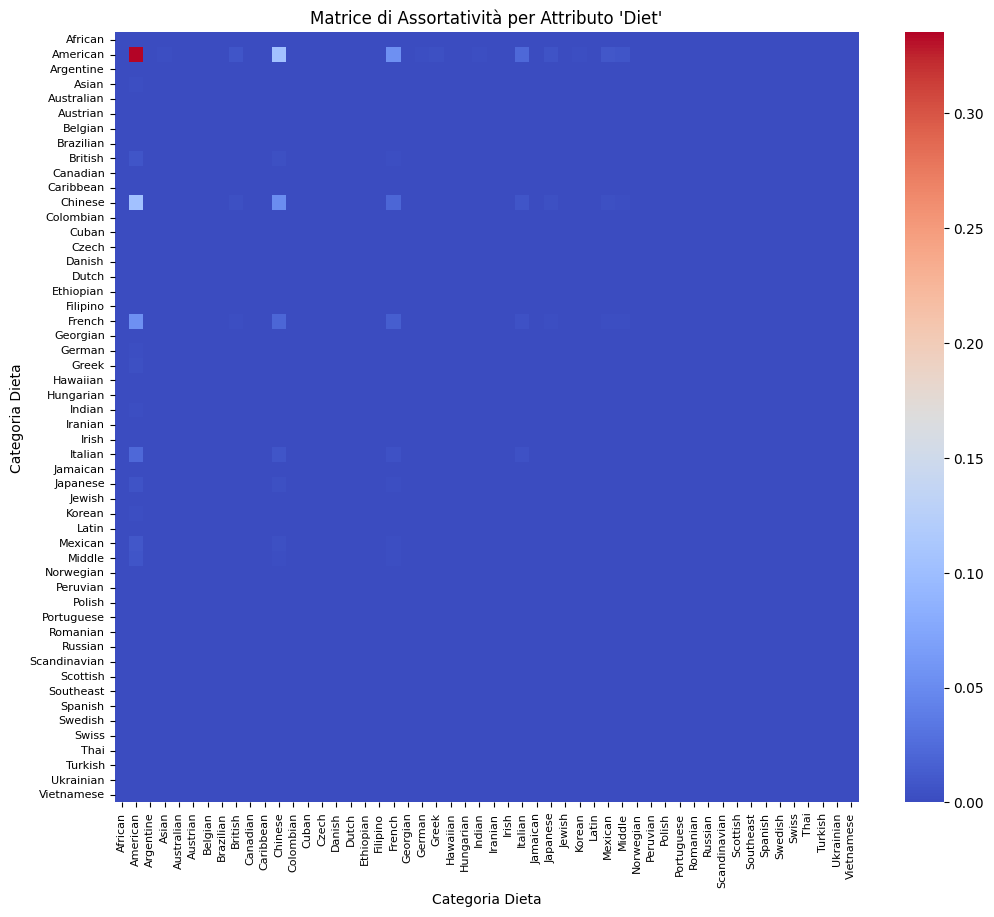

In [ ]:
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Troviamo le categorie uniche ordinate
unique_labels = sorted(set(nx.get_node_attributes(G, "diet").values()))

# Creiamo un dizionario che mappa le categorie ai loro indici
label_to_index = {label: i for i, label in enumerate(unique_labels)}

# Calcoliamo la matrice di assortatività
matrix = nx.attribute_mixing_matrix(G, "diet", normalized=True, mapping=label_to_index)

# Creiamo il plot
plt.figure(figsize=(12, 10))  # Imposta una dimensione più grande per la leggibilità
sns.heatmap(matrix, cmap="coolwarm", annot=False, fmt=".2f", cbar=True,
            xticklabels=unique_labels, yticklabels=unique_labels)

# Miglioriamo il layout
plt.title("Matrice di Assortatività per Attributo 'Diet'")
plt.xlabel("Categoria Dieta")
plt.ylabel("Categoria Dieta")
plt.xticks(rotation=90, fontsize=8)  # Ruotiamo per maggiore leggibilità
plt.yticks(fontsize=8)

plt.show()

In [ ]:
import networkx as nx

def calculate_assortativity_between_american_and_other(G):
    # Controlliamo che i nodi abbiano l'attributo 'label'
    if not all("label" in G.nodes[n] for n in G.nodes):
        raise ValueError("Tutti i nodi devono avere un'etichetta 'label'.")

    # Mappiamo i nodi in due categorie: "American" e "Other"
    node_labels = {}
    for n, data in G.nodes(data=True):
        if data["label"] == "American":
            node_labels[n] = "American"
        else:
            node_labels[n] = "Other"

    # Aggiungiamo l'attributo "diet" per ogni nodo
    nx.set_node_attributes(G, node_labels, "diet")

    # Calcoliamo l'assortatività tra "American" e "Other"
    assortativity = nx.attribute_assortativity_coefficient(G, "diet")

    return assortativity

# Calcoliamo l'assortatività tra "American" e "Other"
assortativity = calculate_assortativity_between_american_and_other(G)

# Stampiamo il risultato
print(f"Assortatività tra 'American' e 'Other': {assortativity:.3f}")


Assortatività tra 'American' e 'Other': 0.074


Non c'è tutta questa differenza/significatività...

Da riprovare nel grafo orientato! Interessante che gli americani abbiano un mixing più evidente, in particolare sembra l'unica etnia che ha una assortatività con sè stessa maggiore che con quella fatta con altri.

Diet modularity

In [ ]:
import networkx as nx
import networkx.algorithms.community as nx_comm

# Definizione della funzione per calcolare la modularità etnica
def calculate_ethnic_modularity(G):
    """
    Calcola la modularità del grafo rispetto alla classificazione etnica.
    """
    # Creiamo le comunità in base alla classificazione etnica
    communities = {}
    for n in G.nodes:
        label = G.nodes[n]["label"]
        if label not in communities:
            communities[label] = set()
        communities[label].add(n)

    community_list = list(communities.values())

    # Calcoliamo la modularità
    return nx_comm.modularity(G, community_list)

# computing and printing out
modularity = calculate_ethnic_modularity(G)
print(f"Modularità rispetto alla classificazione etnica: {modularity:.3f}")

Modularità rispetto alla classificazione etnica: 0.092


In [ ]:
import networkx as nx

def homophily_by_label(G):
    """
    Calcola l'omofilia basata sulle etichette di un grafo G.
    """
    same_label_edges = 0
    total_edges = 0

    for u, v, data in G.edges(data=True):
        total_edges += 1
        if G.nodes[u]['label'] == G.nodes[v]['label']:
            same_label_edges += 1

    return same_label_edges / total_edges if total_edges > 0 else 0


def weighted_homophily(G):
    """
    Calcola l'omofilia ponderata basata sulle etichette di un grafo G.
    """
    same_label_weighted_edges = 0
    total_weighted_edges = 0

    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1)  # Se non c'è peso, assume 1
        total_weighted_edges += weight
        if G.nodes[u]['label'] == G.nodes[v]['label']:
            same_label_weighted_edges += weight

    return same_label_weighted_edges / total_weighted_edges if total_weighted_edges > 0 else 0

# Calcola l'omofilia basata sulle etichette
omofilia_etichetta = homophily_by_label(G)
print(f"Omofilia basata sulle etichette: {omofilia_etichetta:.2f}")

# Calcola l'omofilia ponderata
omofilia_ponderata = weighted_homophily(G)
print(f"Omofilia ponderata: {omofilia_ponderata:.2f}")

Omofilia basata sulle etichette: 0.43
Omofilia ponderata: 0.47


# Other Analysis

Correlation Between Degree and Number of Posts

Average number of posts per user: 2.52
Correlation between number of posts and degree: 0.3171

Top authors by number of posts:
u/kytran40: Count = 389, Degree = 491
u/onemantwohands: Count = 382, Degree = 174
u/Sir_Rule: Count = 300, Degree = 108
u/4food_is_love: Count = 246, Degree = 145
u/balalaikagam3s: Count = 186, Degree = 71
u/fergi20020: Count = 176, Degree = 191
u/kawi-bawi-bo: Count = 172, Degree = 92
u/Ditz3n: Count = 164, Degree = 107
u/pistolpxte: Count = 163, Degree = 164
u/Turtleramem: Count = 157, Degree = 388

Top authors by degree:
u/Sun_Beams: Count = 33, Degree = 3373
u/Sexy_Banker_Lady: Count = 63, Degree = 686
u/kytran40: Count = 389, Degree = 491
u/walkstwomoons2: Count = 24, Degree = 459
u/introvertedalaskan: Count = 3, Degree = 444
u/Turtleramem: Count = 157, Degree = 388
u/Affectionate-Tea-975: Count = 8, Degree = 358
u/cookinwithclint: Count = 103, Degree = 334
u/kymilovechelle: Count = 123, Degree = 327
u/Kitchen_Equipment_21: Count = 2, Degree = 294


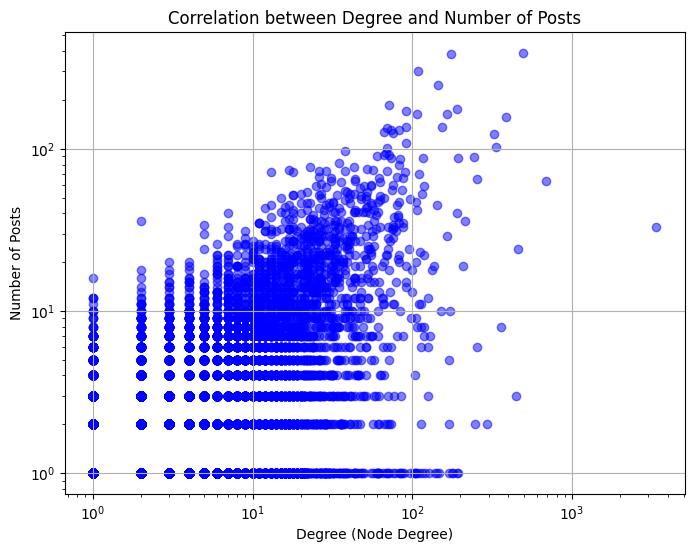

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import scipy.stats as stats

# Load the CSV file
def load_csv(file_path):
    df = pd.read_csv(file_path)
    return df

# Count how many times each author appears
def count_authors(df):
    return df['author'].value_counts().to_dict()

# Compute the degree of the graph (number of connections for each node)
def compute_degree(graph):
    return dict(graph.degree())

# Compare the author counts with their degree
def compare_author_counts_with_degree(graph, author_counts):
    degrees = compute_degree(graph)
    comparison = {
        author: {'count': count, 'degree': degrees.get(author, 0)}
        for author, count in author_counts.items()
    }
    return comparison

# Compute the average number of posts per user
def compute_average_posts(author_counts):
    return sum(author_counts.values()) / len(author_counts) if author_counts else 0

# Calculate the correlation between the number of posts and degree
def compute_correlation(comparison):
    counts = [data['count'] for data in comparison.values()]
    degrees = [data['degree'] for data in comparison.values()]
    correlation, _ = stats.pearsonr(counts, degrees) if counts and degrees else (None, None)
    return correlation

# Filter the top authors by post count and degree
def filter_top_authors(comparison, top_n=10):
    top_by_count = sorted(comparison.items(), key=lambda x: x[1]['count'], reverse=True)[:top_n]
    top_by_degree = sorted(comparison.items(), key=lambda x: x[1]['degree'], reverse=True)[:top_n]
    return top_by_count, top_by_degree

# Add scatter plot between degree and number of posts in logarithmic scale
def plot_scatter(comparison):
    counts = [data['count'] for data in comparison.values()]
    degrees = [data['degree'] for data in comparison.values()]

    plt.figure(figsize=(8, 6))
    plt.scatter(degrees, counts, color='blue', alpha=0.5)
    plt.title('Correlation between Degree and Number of Posts')
    plt.xlabel('Degree (Node Degree)')
    plt.ylabel('Number of Posts')
    plt.xscale('log')  # Logarithmic scale for the X axis
    plt.yscale('log')  # Logarithmic scale for the Y axis
    plt.grid(True)
    plt.show()

# Example usage
if __name__ == "__main__":
    file_path = "/content/gdrive/MyDrive/dati_sna/tag_titles_2022.csv"
    graph = graph  # Assume the graph is already defined elsewhere

    df = load_csv(file_path)
    author_counts = count_authors(df)
    result = compare_author_counts_with_degree(graph, author_counts)

    average_posts = compute_average_posts(author_counts)
    correlation = compute_correlation(result)

    top_by_count, top_by_degree = filter_top_authors(result)

    print(f"Average number of posts per user: {average_posts:.2f}")
    print(f"Correlation between number of posts and degree: {correlation:.4f}")

    print("\nTop authors by number of posts:")
    for author, data in top_by_count:
        print(f"{author}: Count = {data['count']}, Degree = {data['degree']}")

    print("\nTop authors by degree:")
    for author, data in top_by_degree:
        print(f"{author}: Count = {data['count']}, Degree = {data['degree']}")

    # Plot the scatter plot
    plot_scatter(result)


# DIRECTED GRAPH ANALYSIS

Ci sono degli errori grossi in questa parte... da rivedere

## Veg/Omn

Labeling each node, with a majority rule of posted contents, in vegetarian/omnivorous/unknown

In [ ]:
import networkx as nx
import pandas as pd
from collections import Counter

# Carica il CSV
df = pd.read_csv("/content/gdrive/MyDrive/dati_sna/veg_titles_2022_cleaned.csv")

# Troviamo tutte le componenti fortemente connesse (per un grafo diretto)
components = list(nx.weakly_connected_components(graph_directed))

# Troviamo la componente connessa più grande
largest_component = max(components, key=len)

# Creiamo un nuovo grafo contenente solo la componente più grande (preservando i pesi)
G = graph_directed.subgraph(largest_component).copy()

# Crea un dizionario che mappa ogni autore alla classificazione basata su tutte le sue etichette
author_labels = {}
for author, group in df.groupby("author"):
    label_counts = Counter(group["classification"])  # Conta quante volte compaiono vegetarian/omnivorous

    veg_count = label_counts.get("vegetarian", 0)
    omni_count = label_counts.get("omnivorous", 0)

    # Se il numero di vegetariani è uguale a quello degli omnivori, l'etichetta sarà 'unknown'
    if veg_count == omni_count and veg_count > 0:  # Se sono uguali e > 0 → 'unknown'
        author_labels[author] = "unknown"
    else:
        # Altrimenti, assegna l'etichetta più frequente
        most_common_label = max(label_counts, key=label_counts.get)
        author_labels[author] = most_common_label

# Assegna le etichette ai nodi del grafo
to_remove = []  # Per rimuovere eventuali nodi non presenti nel CSV
for node in G.nodes:
    if node in author_labels:
        G.nodes[node]["label"] = author_labels[node]
    else:
        to_remove.append(node)

# Rimuovi nodi che non hanno etichetta
G.remove_nodes_from(to_remove)

Performing label propagation in order to classify the unknown nodes

In [ ]:
import networkx as nx
import random
from collections import Counter

def label_propagation(G, max_iter=100):
    # Iterazione per la propagazione delle etichette
    for _ in range(max_iter):
        for node in G.nodes:
            # Controlla se la label è 'unknown'
            if G.nodes[node].get('label', 'unknown') == 'unknown':
                # Ottieni le etichette dei vicini (sia predecessori che successori in un grafo diretto)
                neighbor_labels = [G.nodes[n]['label'] for n in list(G.successors(node)) + list(G.predecessors(node))
                                   if G.nodes[n].get('label', 'unknown') != 'unknown']

                if neighbor_labels:
                    # Assegna la label più frequente tra i vicini
                    most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
                    G.nodes[node]['label'] = most_common_label
                else:
                    # Se non ci sono vicini con etichette, l'etichetta resta 'unknown' o puoi impostarla a una default
                    G.nodes[node]['label'] = 'unknown'

# Applicare la propagazione delle etichette
label_propagation(G)

valid_labels = {"vegetarian", "omnivorous"}

# Estrai tutte le etichette dei nodi
node_labels = set(nx.get_node_attributes(G, 'label').values())

# Controlla se ci sono solo le etichette attese
if node_labels.issubset(valid_labels):
    print("Tutti i nodi hanno etichette valide.")
else:
    print("Ci sono etichette non valide:", node_labels - valid_labels)


Tutti i nodi hanno etichette valide.


Archi da vegetariani a onnivori: 11998
Archi da onnivori a vegetariani: 11904
Archi da vegetariani a vegetariani: 25744
Archi da onnivori a onnivori: 11002
Numero totale di archi: 60648
Indice di asimmetria: 0.0039

 versione riscalata

Archi da vegetariani a onnivori: 1.0939095550692925
Archi da onnivori a vegetariani: 1.701300557381735
Archi da vegetariani a vegetariani: 2.347191830780452
Archi da onnivori a onnivori: 1.57238816635701


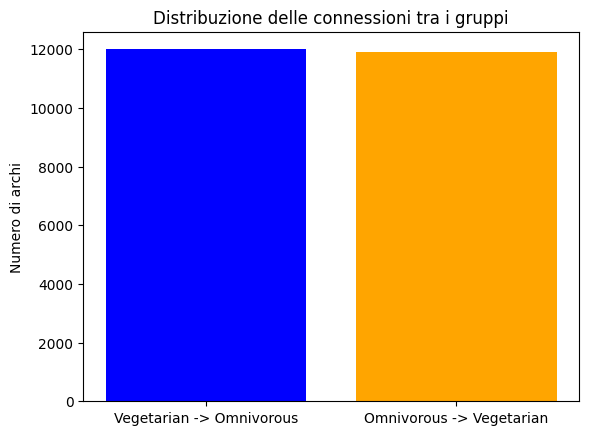

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Supponiamo che 'G' sia il grafo diretto già creato e che i nodi siano etichettati come 'vegetarian' o 'omnivorous'
# Ad esempio, G.nodes[nodo] = 'vegetarian' o 'omnivorous'

# Funzione per calcolare il numero di archi tra i gruppi
def count_edges_by_group(G):
    vegetarian_to_omnivorous = 0
    vegetarian_to_vegetarian = 0
    omnivorous_to_omnivorous = 0
    omnivorous_to_vegetarian = 0
    total_edges = 0

    for u, v in G.edges():
        if G.nodes[u]['label'] == 'vegetarian' and G.nodes[v]['label'] == 'omnivorous':
            vegetarian_to_omnivorous += 1
        if G.nodes[u]['label'] == 'omnivorous' and G.nodes[v]['label'] == 'vegetarian':
            omnivorous_to_vegetarian += 1
        if G.nodes[u]['label'] == 'vegetarian' and G.nodes[v]['label'] == 'vegetarian':
            vegetarian_to_vegetarian += 1
        if G.nodes[u]['label'] == 'omnivorous' and G.nodes[v]['label'] == 'omnivorous':
            omnivorous_to_omnivorous += 1
        total_edges += 1

    return vegetarian_to_omnivorous, omnivorous_to_vegetarian, total_edges, vegetarian_to_vegetarian, omnivorous_to_omnivorous

# Funzione per calcolare l'indice di asimmetria
def compute_asymmetry(vegetarian_to_omnivorous, omnivorous_to_vegetarian):
    if (vegetarian_to_omnivorous + omnivorous_to_vegetarian) == 0:
        return 0
    else:
        # Indice di asimmetria = (differenza / somma totale) tra i flussi di informazioni
        return abs(vegetarian_to_omnivorous - omnivorous_to_vegetarian) / (vegetarian_to_omnivorous + omnivorous_to_vegetarian)

# Calcolare il numero di archi tra i gruppi e l'indice di asimmetria
vegetarian_to_omnivorous, omnivorous_to_vegetarian, total_edges, vegetarian_to_vegetarian, omnivorous_to_omnivorous= count_edges_by_group(G)
asymmetry = compute_asymmetry(vegetarian_to_omnivorous, omnivorous_to_vegetarian)

print(f"Archi da vegetariani a onnivori: {vegetarian_to_omnivorous}")
print(f"Archi da onnivori a vegetariani: {omnivorous_to_vegetarian}")
print(f"Archi da vegetariani a vegetariani: {vegetarian_to_vegetarian}")
print(f"Archi da onnivori a onnivori: {omnivorous_to_omnivorous}")
print(f"Numero totale di archi: {total_edges}")
print(f"Indice di asimmetria: {asymmetry:.4f}")

num_vegetarian = sum(1 for _, data in G.nodes(data=True) if data.get("label") == "vegetarian")
num_omnivorous = sum(1 for _, data in G.nodes(data=True) if data.get("label") == "omnivorous")

print("\n versione riscalata\n")
print(f"Archi da vegetariani a onnivori: {vegetarian_to_omnivorous/num_vegetarian}")
print(f"Archi da onnivori a vegetariani: {omnivorous_to_vegetarian/num_omnivorous}")
print(f"Archi da vegetariani a vegetariani: {vegetarian_to_vegetarian/num_vegetarian}")
print(f"Archi da onnivori a onnivori: {omnivorous_to_omnivorous/num_omnivorous}")

# Creare un grafico per visualizzare la distribuzione degli archi tra i gruppi
def plot_edge_distribution(vegetarian_to_omnivorous, omnivorous_to_vegetarian):
    labels = ['Vegetarian -> Omnivorous', 'Omnivorous -> Vegetarian']
    values = [vegetarian_to_omnivorous, omnivorous_to_vegetarian]

    plt.bar(labels, values, color=['blue', 'orange'])
    plt.title('Distribuzione delle connessioni tra i gruppi')
    plt.ylabel('Numero di archi')
    plt.show()

# Visualizzare la distribuzione degli archi
plot_edge_distribution(vegetarian_to_omnivorous, omnivorous_to_vegetarian)


## Swe/Sav

Labeling each node, with a majority rule of posted contents, in vegetarian/omnivorous/unknown

In [ ]:
import networkx as nx
import pandas as pd
from collections import Counter

# Carica il CSV
df = pd.read_csv("/content/gdrive/MyDrive/dati_sna/sweet_titles_2022_cleaned.csv")

# Troviamo tutte le componenti fortemente connesse (per un grafo diretto)
components = list(nx.weakly_connected_components(graph_directed))

# Troviamo la componente connessa più grande
largest_component = max(components, key=len)

# Creiamo un nuovo grafo contenente solo la componente più grande (preservando i pesi)
G = graph_directed.subgraph(largest_component).copy()

# Crea un dizionario che mappa ogni autore alla classificazione basata su tutte le sue etichette
author_labels = {}
for author, group in df.groupby("author"):
    label_counts = Counter(group["classification"])  # Conta quante volte compaiono vegetarian/omnivorous

    veg_count = label_counts.get("sweet", 0)
    omni_count = label_counts.get("savory", 0)

    # Se il numero di vegetariani è uguale a quello degli omnivori, l'etichetta sarà 'unknown'
    if veg_count == omni_count and veg_count > 0:  # Se sono uguali e > 0 → 'unknown'
        author_labels[author] = "unknown"
    else:
        # Altrimenti, assegna l'etichetta più frequente
        most_common_label = max(label_counts, key=label_counts.get)
        author_labels[author] = most_common_label

# Assegna le etichette ai nodi del grafo
to_remove = []  # Per rimuovere eventuali nodi non presenti nel CSV
for node in G.nodes:
    if node in author_labels:
        G.nodes[node]["label"] = author_labels[node]
    else:
        to_remove.append(node)

# Rimuovi nodi che non hanno etichetta
G.remove_nodes_from(to_remove)

Performing label propagation in order to classify the unknown nodes

In [ ]:
import networkx as nx
import random
from collections import Counter

def label_propagation(G, max_iter=100):
    # Iterazione per la propagazione delle etichette
    for _ in range(max_iter):
        for node in G.nodes:
            # Controlla se la label è 'unknown'
            if G.nodes[node].get('label', 'unknown') == 'unknown':
                # Ottieni le etichette dei vicini (sia predecessori che successori in un grafo diretto)
                neighbor_labels = [G.nodes[n]['label'] for n in list(G.successors(node)) + list(G.predecessors(node))
                                   if G.nodes[n].get('label', 'unknown') != 'unknown']

                if neighbor_labels:
                    # Assegna la label più frequente tra i vicini
                    most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
                    G.nodes[node]['label'] = most_common_label
                else:
                    # Se non ci sono vicini con etichette, l'etichetta resta 'unknown' o puoi impostarla a una default
                    G.nodes[node]['label'] = 'unknown'

# Applicare la propagazione delle etichette
label_propagation(G)

valid_labels = {"sweet", "savory"}

# Estrai tutte le etichette dei nodi
node_labels = set(nx.get_node_attributes(G, 'label').values())

# Controlla se ci sono solo le etichette attese
if node_labels.issubset(valid_labels):
    print("Tutti i nodi hanno etichette valide.")
else:
    print("Ci sono etichette non valide:", node_labels - valid_labels)


Tutti i nodi hanno etichette valide.


Edges from sweet to savory: 2098
Edges from savory to sweet: 4389
Edges from sweet to sweet: 766
Edges from savory to savory: 53395
Total number of edges: 60648
Asymmetry index: 0.3532

 Rescaled version

Edges from sweet to savory (scaled): 1.2646172393007835
Edges from savory to sweet (scaled): 0.26916472464123636
Edges from sweet to sweet (scaled): 0.46172393007836043
Edges from savory to savory (scaled): 3.2745615111002087


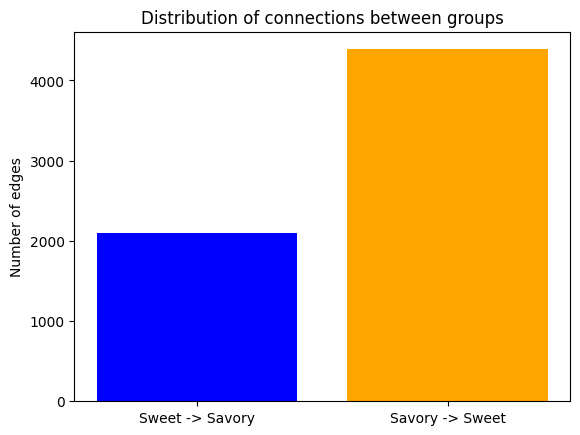

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to count edges between groups
def count_edges_by_group(G):
    sweet_to_savory = 0
    sweet_to_sweet = 0
    savory_to_savory = 0
    savory_to_sweet = 0
    total_edges = 0

    for u, v in G.edges():
        if G.nodes[u]['label'] == 'sweet' and G.nodes[v]['label'] == 'savory':
            sweet_to_savory += 1
        if G.nodes[u]['label'] == 'savory' and G.nodes[v]['label'] == 'sweet':
            savory_to_sweet += 1
        if G.nodes[u]['label'] == 'sweet' and G.nodes[v]['label'] == 'sweet':
            sweet_to_sweet += 1
        if G.nodes[u]['label'] == 'savory' and G.nodes[v]['label'] == 'savory':
            savory_to_savory += 1
        total_edges += 1

    return sweet_to_savory, savory_to_sweet, total_edges, sweet_to_sweet, savory_to_savory

# Function to compute asymmetry index
def compute_asymmetry(sweet_to_savory, savory_to_sweet):
    if (sweet_to_savory + savory_to_sweet) == 0:
        return 0
    else:
        return abs(sweet_to_savory - savory_to_sweet) / (sweet_to_savory + savory_to_sweet)

# Calculate edges between groups and asymmetry index
sweet_to_savory, savory_to_sweet, total_edges, sweet_to_sweet, savory_to_savory = count_edges_by_group(G)
asymmetry = compute_asymmetry(sweet_to_savory, savory_to_sweet)

print(f"Edges from sweet to savory: {sweet_to_savory}")
print(f"Edges from savory to sweet: {savory_to_sweet}")
print(f"Edges from sweet to sweet: {sweet_to_sweet}")
print(f"Edges from savory to savory: {savory_to_savory}")
print(f"Total number of edges: {total_edges}")
print(f"Asymmetry index: {asymmetry:.4f}")

num_sweet = sum(1 for _, data in G.nodes(data=True) if data.get("label") == "sweet")
num_savory = sum(1 for _, data in G.nodes(data=True) if data.get("label") == "savory")

print("\n Rescaled version\n")
print(f"Edges from sweet to savory (scaled): {sweet_to_savory / num_sweet}")
print(f"Edges from savory to sweet (scaled): {savory_to_sweet / num_savory}")
print(f"Edges from sweet to sweet (scaled): {sweet_to_sweet / num_sweet}")
print(f"Edges from savory to savory (scaled): {savory_to_savory / num_savory}")

# Function to plot edge distribution
def plot_edge_distribution(sweet_to_savory, savory_to_sweet):
    labels = ['Sweet -> Savory', 'Savory -> Sweet']
    values = [sweet_to_savory, savory_to_sweet]

    plt.bar(labels, values, color=['blue', 'orange'])
    plt.title('Distribution of connections between groups')
    plt.ylabel('Number of edges')
    plt.show()

# Plot the edge distribution
plot_edge_distribution(sweet_to_savory, savory_to_sweet)



## Ate/Hom

Labeling each node, with a majority rule of posted contents, in sweet/savory/unknown

In [ ]:
import networkx as nx
import pandas as pd
from collections import Counter

# Carica il file CSV
df = pd.read_csv("/content/gdrive/MyDrive/dati_sna/tag_titles_2022.csv")

# Sostituisci tutti i "2" con "1" nella colonna "classification"
df["classification"] = df["classification"].replace("2", "1")

# Ignora o rimuove i valori "unknown" dalla colonna "classification"
df = df[df["classification"] != "unknown"]

# Troviamo tutte le componenti connesse
components = list(nx.weakly_connected_components(graph_directed))

# Troviamo la componente connessa più grande
largest_component = max(components, key=len)

# Ora possiamo creare un nuovo grafo che contenga solo la componente più grande
G = graph_directed.subgraph(largest_component).copy()

# Crea un dizionario che mappa ogni autore alla classificazione più frequente
author_labels = {}
for author, group in df.groupby("author"):
    # Sostituisci i "2" con "1" (già fatto sopra) e calcola la classificazione più frequente
    most_common_label = Counter(group["classification"]).most_common(1)[0][0]
    author_labels[author] = most_common_label

# Assegna le etichette ai nodi
to_remove = []  # Per rimuovere eventuali nodi non presenti nel CSV
for node in G.nodes:
    if node in author_labels:
        G.nodes[node]["label"] = author_labels[node]
    else:
        to_remove.append(node)


Performing label propagation in order to classify the unknown nodes

In [ ]:
import networkx as nx

def label_propagation(G, max_iter=10):
    """Propaga le etichette nel grafo, assegnando ai nodi 'UNKNOWN' la label più frequente tra i vicini."""
    for _ in range(max_iter):
        for node in G.nodes:
            if G.nodes[node]['label'] == 'UNKNOWN':  # Considera solo nodi senza etichetta definita
                # Considera sia predecessori (nodi entranti) che successori (nodi uscenti)
                neighbor_labels = [
                    G.nodes[n]['label']
                    for n in set(G.predecessors(node)) | set(G.successors(node))
                    if G.nodes[n]['label'] != 'UNKNOWN'
                ]

                if neighbor_labels:  # Assegna la label più frequente tra i vicini, se disponibile
                    G.nodes[node]['label'] = max(set(neighbor_labels), key=neighbor_labels.count)

# Applicazione della propagazione delle etichette
label_propagation(G)

# Definizione delle etichette valide
valid_labels = {"0", "1", "2"}

# Estrai tutte le etichette assegnate ai nodi
node_labels = set(nx.get_node_attributes(G, 'label').values())

# Verifica se tutte le etichette sono valide
if node_labels.issubset(valid_labels):
    print("Tutti i nodi hanno etichette valide.")
else:
    print("Ci sono etichette non valide:", node_labels - valid_labels)


Tutti i nodi hanno etichette valide.


Edges from 0 to 1: 8426
Edges from 1 to 0: 7531
Edges from 0 to 0: 2572
Edges from 1 to 1: 42119
Total number of edges: 60648
Asymmetry index: 0.0561

 Rescaled version

Edges from 0 to 1 (scaled): 2.4373734451836855
Edges from 1 to 0 (scaled): 0.5190929142542046
Edges from 0 to 0 (scaled): 0.7439976858547874
Edges from 1 to 1 (scaled): 2.9031568789633306


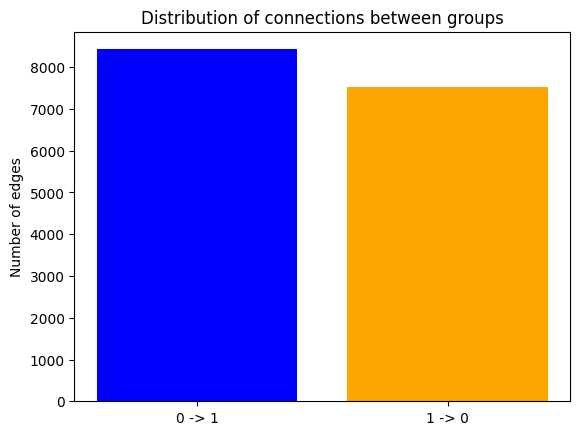

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Funzione per contare i collegamenti tra i gruppi
def count_edges_by_group(G):
    zero_to_one = 0  # 0 -> 1
    zero_to_zero = 0  # 0 -> 0
    one_to_one = 0  # 1 -> 1
    one_to_zero = 0  # 1 -> 0
    total_edges = 0

    # Controllo degli edge tra i gruppi
    for u, v in G.edges():
        if G.nodes[u]['label'] == '0' and G.nodes[v]['label'] == '1':
            zero_to_one += 1
        if G.nodes[u]['label'] == '1' and G.nodes[v]['label'] == '0':
            one_to_zero += 1
        if G.nodes[u]['label'] == '0' and G.nodes[v]['label'] == '0':
            zero_to_zero += 1
        if G.nodes[u]['label'] == '1' and G.nodes[v]['label'] == '1':
            one_to_one += 1
        total_edges += 1

    return zero_to_one, one_to_zero, total_edges, zero_to_zero, one_to_one

# Funzione per calcolare l'indice di asimmetria
def compute_asymmetry(zero_to_one, one_to_zero):
    if (zero_to_one + one_to_zero) == 0:
        return 0
    else:
        return abs(zero_to_one - one_to_zero) / (zero_to_one + one_to_zero)

# Calcolare gli edge tra i gruppi e l'indice di asimmetria
zero_to_one, one_to_zero, total_edges, zero_to_zero, one_to_one = count_edges_by_group(G)
asymmetry = compute_asymmetry(zero_to_one, one_to_zero)

print(f"Edges from 0 to 1: {zero_to_one}")
print(f"Edges from 1 to 0: {one_to_zero}")
print(f"Edges from 0 to 0: {zero_to_zero}")
print(f"Edges from 1 to 1: {one_to_one}")
print(f"Total number of edges: {total_edges}")
print(f"Asymmetry index: {asymmetry:.4f}")

# Calcolare la versione ridimensionata
num_zero = sum(1 for _, data in G.nodes(data=True) if data.get("label") == "0")
num_one = sum(1 for _, data in G.nodes(data=True) if data.get("label") == "1")

print("\n Rescaled version\n")
print(f"Edges from 0 to 1 (scaled): {zero_to_one / num_zero}")
print(f"Edges from 1 to 0 (scaled): {one_to_zero / num_one}")
print(f"Edges from 0 to 0 (scaled): {zero_to_zero / num_zero}")
print(f"Edges from 1 to 1 (scaled): {one_to_one / num_one}")

# Funzione per tracciare la distribuzione degli edge
def plot_edge_distribution(zero_to_one, one_to_zero):
    labels = ['0 -> 1', '1 -> 0']
    values = [zero_to_one, one_to_zero]

    plt.bar(labels, values, color=['blue', 'orange'])
    plt.title('Distribution of connections between groups')
    plt.ylabel('Number of edges')
    plt.show()

# Traccia la distribuzione degli edge
plot_edge_distribution(zero_to_one, one_to_zero)


## Ethnicity

In [ ]:
import networkx as nx
import pandas as pd
from collections import Counter
from google.colab import drive

# Caricare Google Drive
drive.mount('/content/gdrive')

# Carica il CSV
df = pd.read_csv("/content/gdrive/MyDrive/dati_sna/ethnic_titles_2022_cleaned.csv")

# Troviamo tutte le componenti connesse
components = list(nx.weakly_connected_components(graph_directed))

# Troviamo la componente connessa più grande
largest_component = max(components, key=len)

# Creiamo un nuovo grafo contenente solo la componente più grande (preservando i pesi)
G = graph_directed.subgraph(largest_component).copy()

# Lista delle classificazioni valide
valid_classifications = ["American", "Chinese", "French", "Italian", "Mexican", "Japanese", "Middle",
                         "British", "Indian", "Greek", "Korean", "German", "Spanish", "Vietnamese",
                         "Asian", "Russian", "Caribbean", "Hawaiian", "African", "Brazilian", "Turkish",
                         "Polish", "Jewish", "Latin", "Irish", "Southeast", "Australian", "Thai", "Canadian",
                         "Swedish", "Filipino", "Scottish", "Portuguese", "Peruvian", "Hungarian", "Dutch",
                         "Scandinavian", "Georgian", "Ukrainian", "Ethiopian", "Belgian", "Swiss", "Jamaican",
                         "Cuban", "Persian", "Argentine", "Romanian", "Czech", "Iranian", "Danish",
                         "Austrian", "Norwegian", "Colombian"]

# Crea un dizionario che mappa ogni autore alla classificazione basata su tutte le sue etichette
author_labels = {}
for author, group in df.groupby("author"):
    label_counts = Counter(group["classification"])

    # Conta le occorrenze delle classificazioni valide
    valid_counts = {label: label_counts.get(label, 0) for label in valid_classifications}

    # Se ci sono più etichette con lo stesso numero di occorrenze, assegna "unknown"
    if len(set(valid_counts.values())) == 1 and sum(valid_counts.values()) > 0:
        author_labels[author] = "unknown"
    else:
        # Altrimenti, assegna l'etichetta più frequente
        most_common_label = max(valid_counts, key=valid_counts.get)
        author_labels[author] = most_common_label

# Assegna le etichette ai nodi del grafo
to_remove = []  # Per rimuovere eventuali nodi non presenti nel CSV
for node in G.nodes:
    if node in author_labels:
        G.nodes[node]["label"] = author_labels[node]
    else:
        to_remove.append(node)

# Rimuovi nodi che non hanno etichetta
G.remove_nodes_from(to_remove)

print("Etichette assegnate alla componente più grande del grafo.")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Etichette assegnate alla componente più grande del grafo.


In [ ]:
import networkx as nx
import random

# Definizione della funzione di propagazione delle etichette
def label_propagation(G, max_iter=10):
    for _ in range(max_iter):
        for node in G.nodes:
            if G.nodes[node]['label'] == 'unknown':
                neighbor_labels = [G.nodes[n]['label'] for n in G.neighbors(node) if G.nodes[n]['label'] != 'unknown']
                if neighbor_labels:
                    # Assegna la label più frequente tra i vicini
                    G.nodes[node]['label'] = max(set(neighbor_labels), key=neighbor_labels.count)

# Applicare la propagazione delle etichette
label_propagation(G)

valid_labels = {"American", "Chinese", "French", "Italian", "Mexican", "Japanese", "Middle",
                "British", "Indian", "Greek", "Korean", "German", "Spanish", "Vietnamese",
                "Asian", "Russian", "Caribbean", "Hawaiian", "African", "Brazilian", "Turkish",
                "Polish", "Jewish", "Latin", "Irish", "Southeast", "Australian", "Thai", "Canadian",
                "Swedish", "Filipino", "Scottish", "Portuguese", "Peruvian", "Hungarian", "Dutch",
                "Scandinavian", "Georgian", "Ukrainian", "Ethiopian", "Belgian", "Swiss", "Jamaican",
                "Cuban", "Persian", "Argentine", "Romanian", "Czech", "Iranian", "Danish",
                "Austrian", "Norwegian", "Colombian"}

# Estrai tutte le etichette dei nodi
node_labels = set(nx.get_node_attributes(G, 'label').values())

# Controlla se ci sono solo le etichette attese
if node_labels.issubset(valid_labels):
    print("Tutti i nodi hanno etichette valide.")
else:
    print("Ci sono etichette non valide:", node_labels - valid_labels)

Tutti i nodi hanno etichette valide.


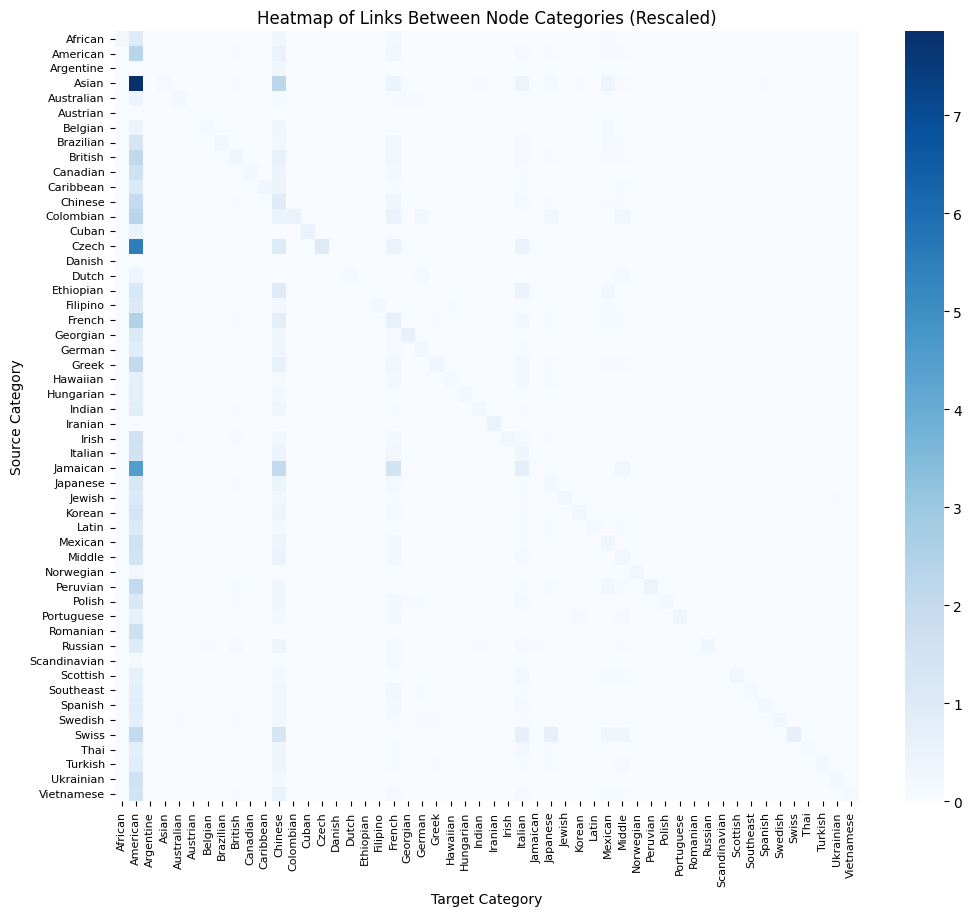

In [ ]:
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Extract unique node labels
unique_labels = sorted(set(nx.get_node_attributes(G, "label").values()))

# Create a dictionary mapping labels to matrix indices
label_to_index = {label: i for i, label in enumerate(unique_labels)}

# Count the number of nodes for each label
label_counts = {label: sum(1 for n in G.nodes if G.nodes[n].get("label") == label) for label in unique_labels}

# Initialize the matrix for counting links between categories
matrix = np.zeros((len(unique_labels), len(unique_labels)))

# Count the links between categories and rescale them
for u, v in G.edges():
    u_label = G.nodes[u].get("label")
    v_label = G.nodes[v].get("label")

    if u_label in label_to_index and v_label in label_to_index and label_counts[u_label] > 0:
        matrix[label_to_index[u_label], label_to_index[v_label]] += 1

# Rescale the values by dividing by the number of nodes in the source category
for i, label in enumerate(unique_labels):
    if label_counts[label] > 0:
        matrix[i, :] /= label_counts[label]

# Create the heatmap without numbers
plt.figure(figsize=(12, 10))
sns.heatmap(matrix, cmap="Blues", annot=False, cbar=True,
            xticklabels=unique_labels, yticklabels=unique_labels)

# Improve layout
plt.title("Heatmap of Links Between Node Categories (Rescaled)")
plt.xlabel("Target Category")
plt.ylabel("Source Category")
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

plt.show()


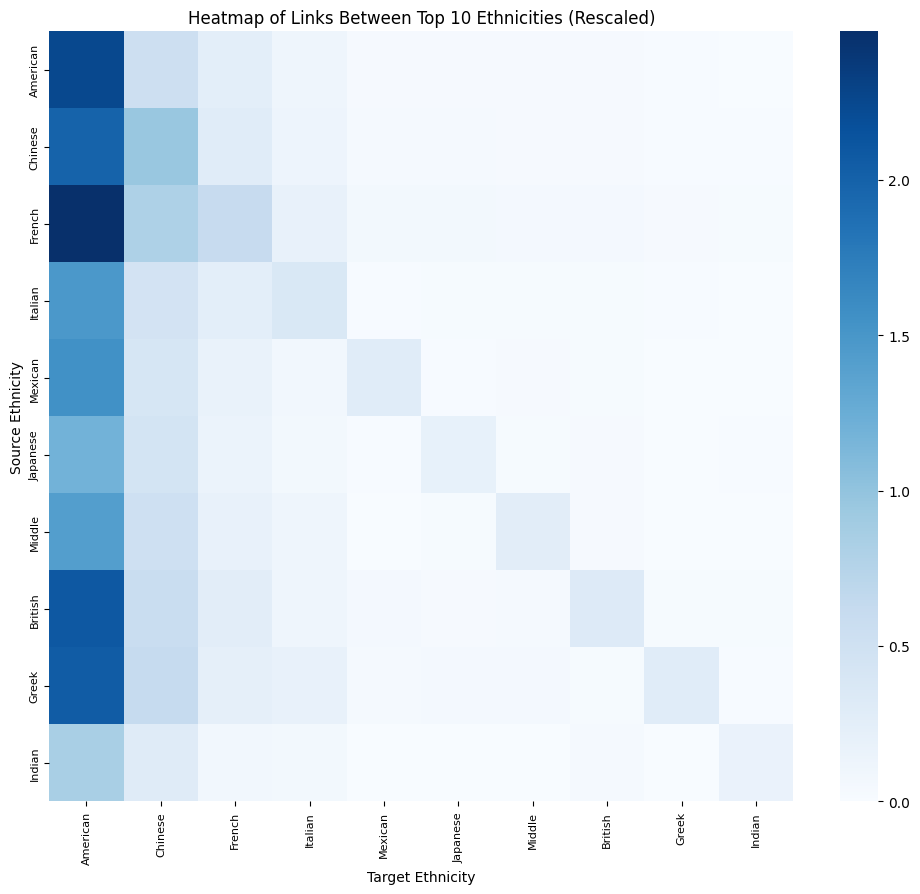

In [ ]:
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Extract node labels (ethnicities)
node_labels = nx.get_node_attributes(G, "label")

# Count occurrences of each ethnicity
label_counts = {}
for label in node_labels.values():
    label_counts[label] = label_counts.get(label, 0) + 1

# Select the top 10 ethnicities with the most nodes
top_labels = sorted(label_counts, key=label_counts.get, reverse=True)[:10]

# Filter nodes that belong to the top 10 ethnicities
filtered_nodes = {n for n in G.nodes if G.nodes[n].get("label") in top_labels}

# Create a mapping of selected labels to matrix indices
label_to_index = {label: i for i, label in enumerate(top_labels)}

# Initialize adjacency matrix
matrix = np.zeros((len(top_labels), len(top_labels)))

# Count edges between selected ethnicities and rescale
for u, v in G.edges():
    u_label = G.nodes[u].get("label")
    v_label = G.nodes[v].get("label")

    if u_label in label_to_index and v_label in label_to_index:
        matrix[label_to_index[u_label], label_to_index[v_label]] += 1

# Normalize by the number of nodes in the source category
for i, label in enumerate(top_labels):
    if label_counts[label] > 0:
        matrix[i, :] /= label_counts[label]

# Plot heatmap without numbers
plt.figure(figsize=(12, 10))
sns.heatmap(matrix, cmap="Blues", annot=False, cbar=True,
            xticklabels=top_labels, yticklabels=top_labels)

# Improve layout
plt.title("Heatmap of Links Between Top 10 Ethnicities (Rescaled)")
plt.xlabel("Target Ethnicity")
plt.ylabel("Source Ethnicity")
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

plt.show()
